<a href="https://colab.research.google.com/github/grantrzchan/HTX_Armed_Robberies/blob/master/HTX_Robberies_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()


Saving HTX_robberies.csv to HTX_robberies.csv


In [0]:
import sklearn as skl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from math import sqrt
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

'''Predict number of armed robberies in Houston, TX,
based on data from previous time step. Data is monthly between
June 2009 and Apr 2020'''

#load data into pandas Series
raw_data = pd.read_csv('HTX_robberies.csv', index_col=0, header=None, squeeze=True)

In [13]:
raw_data

0
2009-06     982.0
2009-07    1081.0
2009-08    1034.0
2009-09    1021.0
2009-10     930.0
            ...  
2019-12     900.0
2020-01     910.0
2020-02     721.0
2020-03     681.0
2020-04     456.0
Name: 1, Length: 131, dtype: float64

In [0]:
# write function that convert series to supervised learning training examples and targets
"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
raw = raw_data.values
# ensure all data is float
raw = raw.astype('float32')
# normalize features
scaler = skl.preprocessing.MinMaxScaler(feature_range=(0, 1))
#since we only have a single feature, we need to reshape it before normalizing
raw = raw.reshape(-1,1)
scaled = scaler.fit_transform(raw)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [17]:
reframed

,var1(t-1),var1(t)
1,0.833598,0.990491
2,0.990491,0.916006
3,0.916006,0.895404
4,0.895404,0.751189
5,0.751189,0.757528
...,...,...
126,0.645008,0.703645
127,0.703645,0.719493
128,0.719493,0.419968
129,0.419968,0.356577


In [76]:
# split into train, test and cross-validation sets
#Use the LSTM model in Keras for CV sets
data = reframed.values
data_set = data
#let's arbitrarily select 80% of the data_set as training data, 20% as test
train_size = int(0.8*len(data_set))
train = data_set[:train_size]
test = data_set[train_size:]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(104, 1, 1) (104,) (26, 1, 1) (26,)


Train on 104 samples, validate on 26 samples
Epoch 1/100
 - 0s - loss: 0.4620 - accuracy: 0.0000e+00 - val_loss: 0.3149 - val_accuracy: 0.0385
Epoch 2/100
 - 0s - loss: 0.3454 - accuracy: 0.0000e+00 - val_loss: 0.2077 - val_accuracy: 0.0385
Epoch 3/100
 - 0s - loss: 0.2208 - accuracy: 0.0000e+00 - val_loss: 0.1147 - val_accuracy: 0.0385
Epoch 4/100
 - 0s - loss: 0.1316 - accuracy: 0.0096 - val_loss: 0.1223 - val_accuracy: 0.0385
Epoch 00004: early stopping


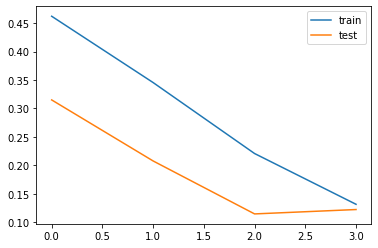

In [77]:
#design LSTM network
#use early stopping to decide when to terminate model training
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=5, 
                    validation_data=(test_X, test_y), verbose=2, 
                    shuffle=False, callbacks=[es])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
# make a prediction
test_X.shape
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


Test RMSE: 102.394


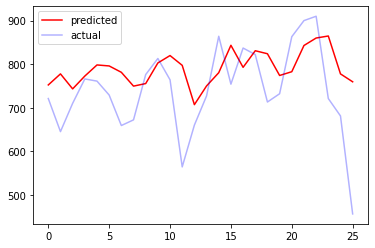

In [79]:
# calculate RMSE
rmse = sqrt(mse(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
predicted = plt.plot(inv_yhat, color='red', alpha=1)
actual = plt.plot(inv_y, color='blue', alpha=0.3)
plt.legend(['predicted','actual'])
plt.show()

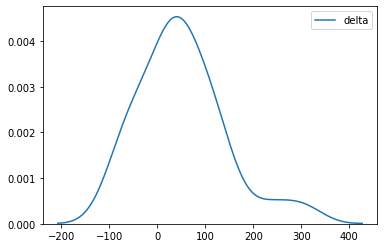

In [80]:
result = pd.DataFrame({'predicted': inv_yhat,'actual': inv_y})
result['delta'] = result['predicted'] - result['actual']
sns.kdeplot(result['delta'], shade=False)